In [1]:
import cv2
from google.cloud import vision
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import urllib
import imutils
import pytesseract
import os
from google.colab.patches import cv2_imshow
%matplotlib inline

/home/khanh/anaconda3/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [28]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='/media/khanh/New Volume1/Workspace/Project/DevC-FE-Credit/config/google api key.json'

In [3]:
print(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS'))

/media/khanh/New Volume/Workspace/DevC/Project/api key.json


In [25]:
# image_uri = 'https://i.imgur.com/Bf6DQFQ.png'

# client = vision.ImageAnnotatorClient()
# image = vision.types.Image()
# image.source.image_uri = image_uri

# response = client.label_detection(image=image)

# print('Labels (and confidence score):')
# print('=' * 79)
# for label in response.label_annotations:
#     print(f'{label.description} ({label.score*100.:.2f}%)')

In [3]:
def urlToImage(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  return image

In [4]:
def displayImage(image):
    cv2_imshow(image)

In [5]:
imgsrc = {
  'normal': 'https://i.imgur.com/nNetKsv.jpg',
  'tilted': 'https://i.imgur.com/lkeXtc9.png',
  'tiltedText': 'https://i.stack.imgur.com/ouy3d.jpg',
  'normal-2': 'https://i.imgur.com/4Q8M7xg.jpg',
  'normal-3': 'https://i.imgur.com/Mhnn80V.jpg',
  'normal-4': 'https://i.imgur.com/vZViT6j.jpg',
  'normal-5': 'https://i.imgur.com/kHfSVg2.jpg',
  'cleaned': 'https://i.imgur.com/TFJaLQa.jpg',
  'sharped': 'https://i.imgur.com/SS53U2m.png'
}

In [6]:
def findContour(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 10, 50)
    cnts, h = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
    screenCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            screenCnt = approx
            break

    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)

    return screenCnt

In [7]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

In [8]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

In [9]:
def remove_noise_and_smooth(image):
    img = image
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 41)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

In [10]:
def blurImage(image):
    clear = cv2.fastNlMeansDenoisingColored(image,None,20,10,7,21)
    return clear  

In [11]:
def blurGrayImage(image):
    clear = cv2.fastNlMeansDenoising(image,None,20,10,7,21)
    return clear  

In [12]:
def convert_to_binary(img_grayscale, thresh=100):
    #   img_binary = cv2.adaptiveThreshold(img_grayscale, 
    #                                      maxValue=255, 
    #                                      adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    #                                      thresholdType=cv2.THRESH_BINARY,
    #                                      blockSize=15,
    #                                      C=8)
    rect, img_binary = cv2.threshold(img_grayscale,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return img_binary

In [13]:
def sharpeningImage(image):
    kernel_sharpening = np.array([[-1,-1,-1], 
                                  [-1, 9,-1],
                                  [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, kernel_sharpening)
    return sharpened

In [14]:
def grayImage(image):
  gray = cv2.cvtColor(clear, cv2.COLOR_BGR2GRAY)
  return gray

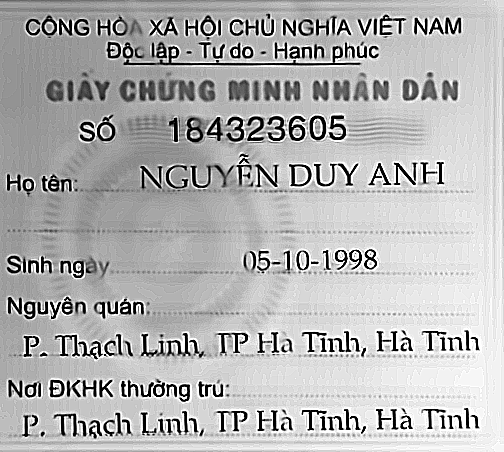

In [16]:
image = urlToImage(imgsrc['normal-2'])

imgWithContour = image.copy()
screenCnt = findContour(imgWithContour)

pts = np.array(screenCnt.reshape(4, 2) * 1)
order_points(pts)

result = four_point_transform(image, pts)
result = result[0:result.shape[0], int(result.shape[1] * 0.3) : 764]

clear = blurImage(result)
gray = grayImage(clear)
sharp = sharpeningImage(gray)
binary = convert_to_binary(sharp)
displayImage(sharp)

In [141]:
print(pytesseract.image_to_string(sharp))

ONG HOA XA HO! CHU NGHIA VIET NAM
Doc lap _ Tu do - Hanh phuc

HUNG MINH NHAN DAN
SO 145064321
Hoten NGUYEN BAO NGOC

Sinh ngay 07-09-1983

Nguyén quan Binh Minh
Khoai Chau, Hung Yén |

Noi OKHK thudng tru Binh Minh
Khoai Chau, Hung Yén _


In [142]:
client = vision.ImageAnnotatorClient()

response = client.text_detection(image=image)

print(response)

# for text in response.text_annotations:
#     print('=' * 79)
#     print(f'"{text.description}"')
#     vertices = [f'({v.x},{v.y})' for v in text.bounding_poly.vertices]
#     print(f'bounds: {",".join(vertices)}')

TypeError: get() expected a dict or protobuf message, got <class 'numpy.ndarray'>.

In [5]:
from google.cloud.vision import types
image_uri = 'https://i.imgur.com/Bf6DQFQ.png'

# image_uri = imgsrc['normal']
client = vision.ImageAnnotatorClient()
image = types.Image()
image.source.image_uri = image_uri

response = client.document_text_detection(image=image)

In [6]:
print(response.text_annotations[0].description)

CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM
| Độc lập Tự do - Hạnh phúc
GIẤY CHỨNG CHÍNH NHÂN DÂN
SÓ 145064321
Họ tên. NGUYÊN BẢO NGỌC
| Sinh ngày
07-09-1983
| Nguyên quan Bình Minh
Khoái Châu, Hưng Yên
Nơi ĐKHK thường trú Bình Minh.
Khoái Châu, Hưng Yên



In [178]:
arr = list(response.text_annotations[0].description.split('\n'))

In [183]:
arr

['cộng hòa xã hội chủ nghĩa việt nam',
 '| độc lập tự do - hạnh phúc',
 'giấy chứng chính nhân dân',
 'só 145064321',
 'họ tên. nguyên bảo ngọc',
 '| sinh ngày',
 '07-09-1983',
 '| nguyên quan bình minh',
 'khoái châu, hưng yên',
 'nơi đkhk thường trú bình minh.',
 'khoái châu, hưng yên',
 '']

In [182]:
for i in range(len(arr)):
    arr[i] = arr[i].lower()

In [17]:
img = urlToImage(imgsrc['normal-2'])

In [32]:
success, encoded_image = cv2.imencode('.jpg', sharp)
encoded_image

array([[255],
       [216],
       [255],
       ...,
       [ 95],
       [255],
       [217]], dtype=uint8)

In [33]:
from google.cloud import vision
client = vision.ImageAnnotatorClient()
content2 = encoded_image.tobytes()
image_cv2 = vision.types.Image(content=content2)
response =  client.text_detection(image=image_cv2)
response

text_annotations {
  locale: "vi"
  description: "CONG HOA XA HOI CHU NGHIA VI\303\212T NAM\nD\341\273\231c lap - Tu do- Hanh ph\303\272c\nGIAY CHUNG MINH NNAN DAN\n184323605\nNGUY\303\212N DUY ANH\nSo\nHo t\303\252n:\n05-10-1998\nSinh ngay\nNguy\303\252n qu\303\241n\nP. Thach Linh, TP Ha Tinh, H\303\240 Tinh\nNdl DKHK thuong tr\303\272:\nP. Thach Linh, TP H\303\240 Tinh, H\303\240 Tinh\n"
  bounding_poly {
    vertices {
      x: 7
      y: 12
    }
    vertices {
      x: 478
      y: 12
    }
    vertices {
      x: 478
      y: 439
    }
    vertices {
      x: 7
      y: 439
    }
  }
}
text_annotations {
  description: "CONG"
  bounding_poly {
    vertices {
      x: 26
      y: 15
    }
    vertices {
      x: 88
      y: 15
    }
    vertices {
      x: 88
      y: 37
    }
    vertices {
      x: 26
      y: 37
    }
  }
}
text_annotations {
  description: "HOA"
  bounding_poly {
    vertices {
      x: 98
      y: 15
    }
    vertices {
      x: 141
      y: 15
    }
    ver

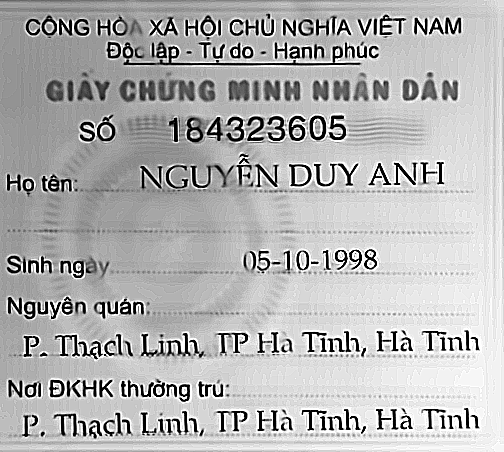

In [30]:
displayImage(sharp)

In [34]:
response.text_annotations[0].description

'CONG HOA XA HOI CHU NGHIA VIÊT NAM\nDộc lap - Tu do- Hanh phúc\nGIAY CHUNG MINH NNAN DAN\n184323605\nNGUYÊN DUY ANH\nSo\nHo tên:\n05-10-1998\nSinh ngay\nNguyên quán\nP. Thach Linh, TP Ha Tinh, Hà Tinh\nNdl DKHK thuong trú:\nP. Thach Linh, TP Hà Tinh, Hà Tinh\n'